In [1]:
from sklearn.cluster import *
import scipy
import copy
import numpy as np
from matplotlib import pyplot as plt
from Bio import AlignIO
import pickle
import h5py
import dendropy
#todo. blur mat up and down tree
#todo. group codons
import os
os.environ['MKL_ENABLE_INSTRUCTIONS'] = 'AVX2'


In [2]:
treefile = '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/gisaid_hcov-2020_07_02.QC.NSoutlier.filter.NSmask.aln.treefile'
alnfile = '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/gisaid_hcov-2020_07_02.QC.NSoutlier.filter.NSmask.aln'
outsankof = './coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/gisaid_hcov-2020_07_02.QC.NSoutlier.filter.NSmask.alnCOEV_cleantreecoevmatrev3.pkl'

In [3]:
treefile = '/home/cactuskid13/covid/lucy_mk2/30_07_2020/gisaid_hcov-2020_07_30.QC.NSoutlier.filter.deMaiomask.aln.EPIID.HF.treefile'
alnfile = '/home/cactuskid13/covid/lucy_mk2/30_07_2020/gisaid_hcov-2020_07_30.QC.NSoutlier.filter.deMaiomask.EPIID.HF.noambig.aln'
outsankof = './lucy_mk2/30_07_2020/gisaid_hcov-2020_07_30.QC.NSoutlier.filter.deMaiomask.EPIID.HF.noambig.HomoplasyFinder_input.alnCOEV_cleantree_mk4coevmatrev3.pkl'

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(93445, 29903)
1.0


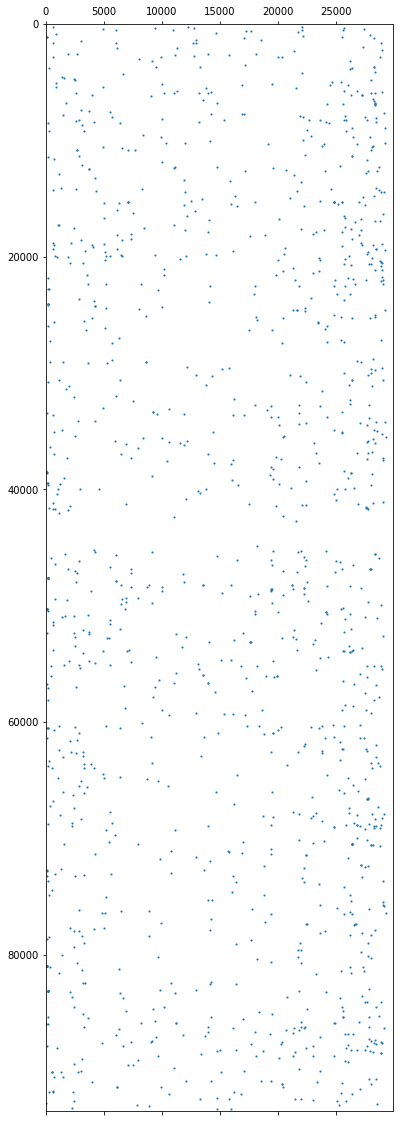

In [4]:
#load sankoff coev mat
with open( outsankof , 'rb') as matin:
    coevmat = pickle.loads(matin.read())
coevmat = coevmat.todense()
print(coevmat)
print(coevmat.shape)
print(np.amax(coevmat))

plt.figure( figsize=(30,20))
plt.spy(coevmat, markersize= 1)
plt.show()

In [5]:
sumv = np.sum(coevmat , axis = 0)
print(sumv.ravel().shape)
print(np.amax(sumv))
print(np.amin(sumv))
print(np.mean(sumv))
print(np.mean(sumv[sumv>0]))
print(np.std(sumv))

(1, 29903)
5.0
0.0
0.043106042871952646
1.4697833523375143
0.2779045225933301


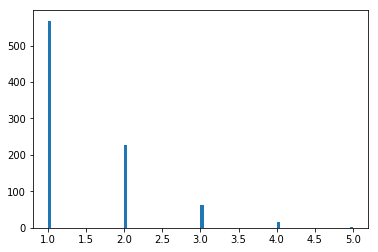

In [6]:
counts,bins = np.histogram(sumv[sumv>0].ravel() , bins = 100)
centroids = (bins[1:] + bins[:-1]) / 2
counts_, bins_, _ = plt.hist(centroids, bins=len(counts),
                             weights=counts, range=(min(bins), max(bins)))

In [7]:
#create the connectivity mat and use it to blur the coev mat
tree = dendropy.Tree.get(
    path=treefile,
    schema='newick')
for l in tree.leaf_nodes()[0:10]:
    print(str(l.taxon))
print(len(tree.leaf_nodes()))
print('leaves')

for i,n in enumerate(tree.nodes()):
    n.matrow = i
    n.symbols = None
    n.scores = None
    n.event = None
    n.char = None
matsize = len(tree.nodes())
print(matsize)
print('nodes')



'EPI ISL 475681'
'EPI ISL 458210'
'EPI ISL 416583'
'EPI ISL 425849'
'EPI ISL 425869'
'EPI ISL 419227'
'EPI ISL 419242'
'EPI ISL 417432'
'EPI ISL 419228'
'EPI ISL 421230'
46723
leaves
93445
nodes


In [8]:
#blur w connectivity mat
blurfactor =  .5
bluriter = 4
connectmat = scipy.sparse.lil_matrix((len(tree.nodes()), len(tree.nodes() ) ) )
index = np.array([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
connectmat[index[:,0],index[:,1]] = 1
connectmat+= connectmat.T

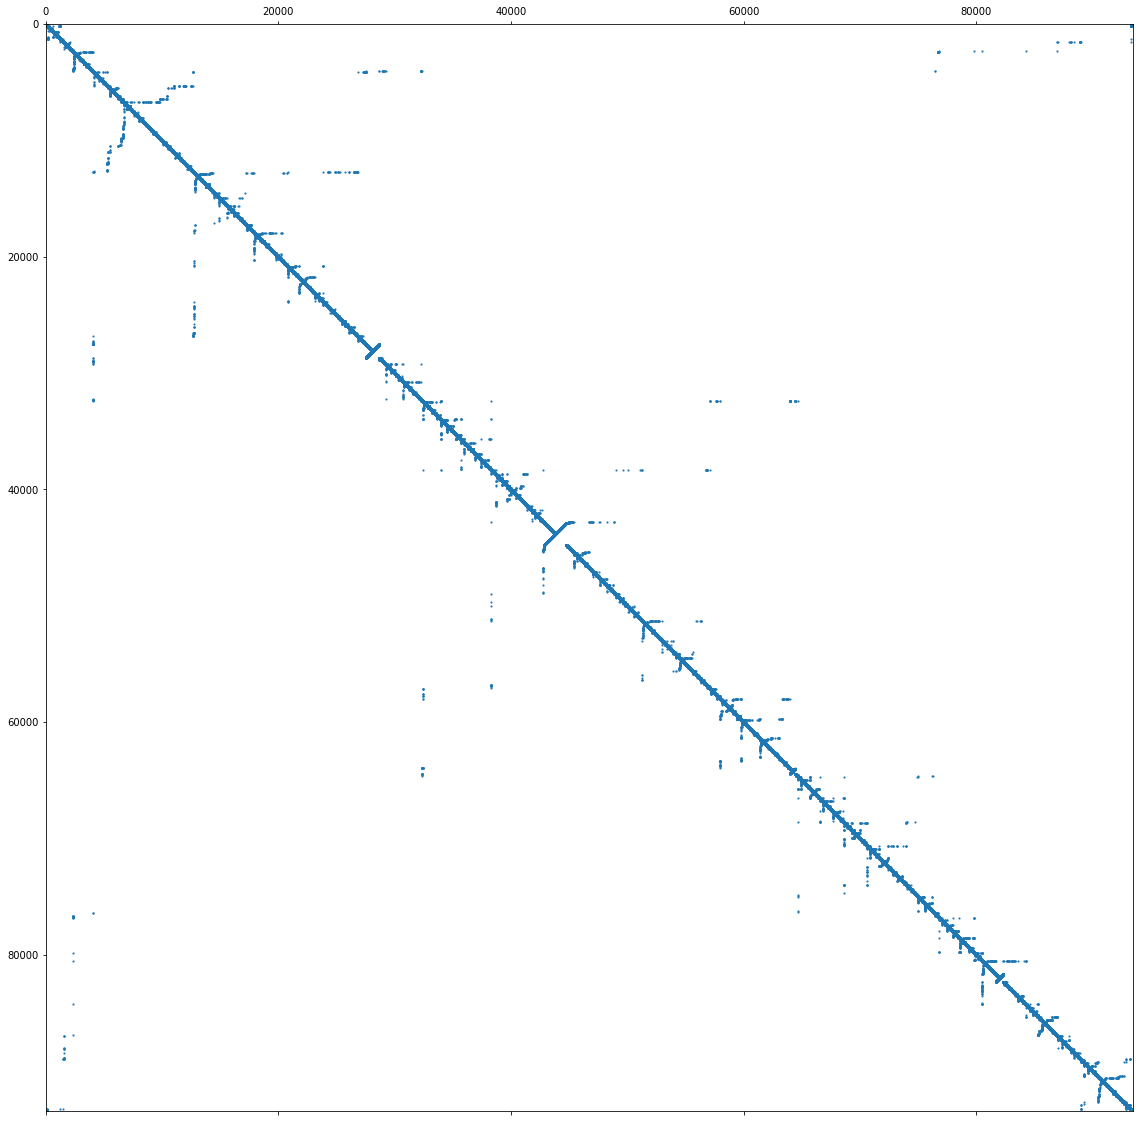

In [9]:
plt.figure( figsize=(20,20))
plt.spy(connectmat, markersize= 1)
plt.show()

In [10]:
#apply blur a few times
blurmat = copy.deepcopy(scipy.sparse.lil_matrix(coevmat))
print(connectmat.shape)
print(blurmat.shape)
for i in range( bluriter):
    blurmat += np.dot(blurfactor*connectmat, blurmat)
    print('blurring')
    print(i)

(93445, 93445)
(93445, 29903)
blurring
0
blurring
1
blurring
2
blurring
3


In [11]:
with open(alnfile+'blurmatr3.pkl' , 'wb') as blurout:
    blurout.write( pickle.dumps(blurmat ))


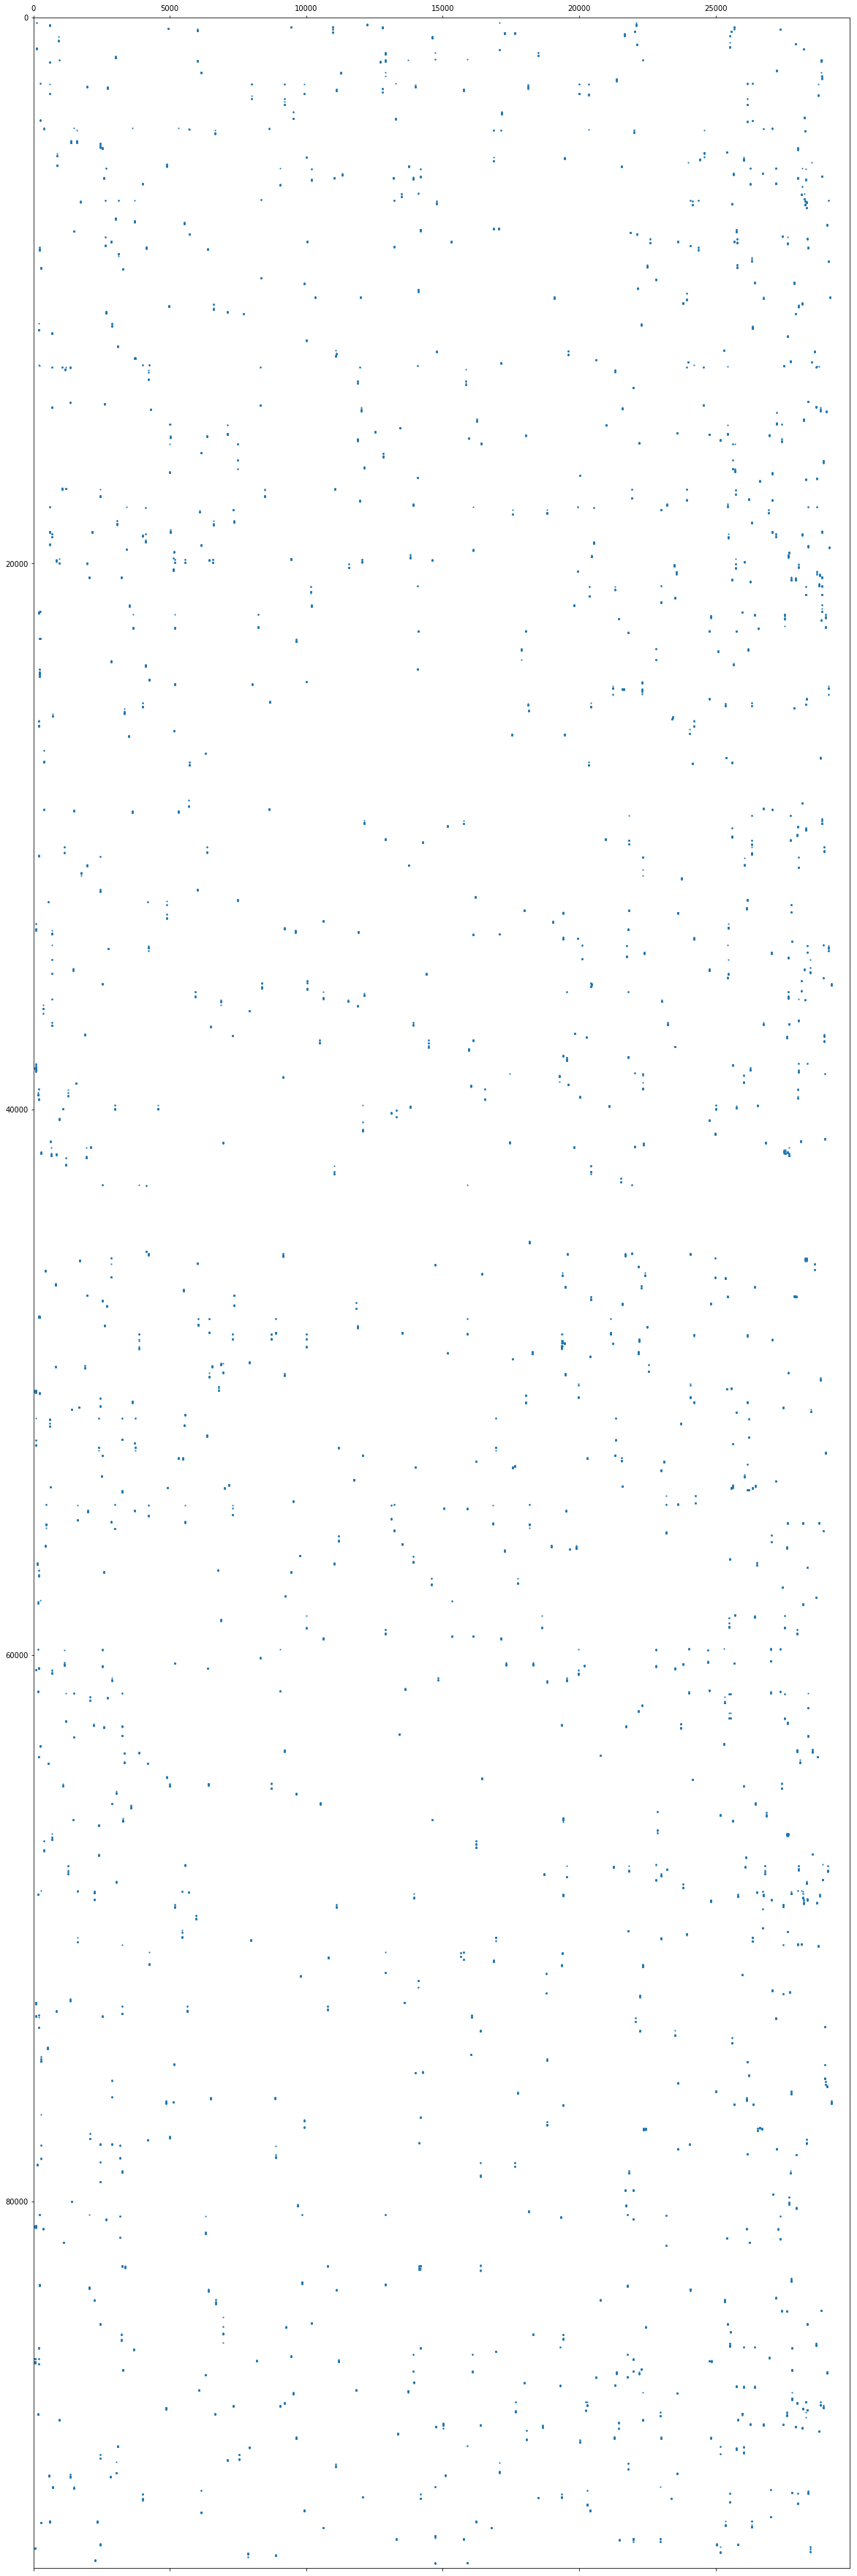

In [12]:
plt.figure( figsize=(20,200))
plt.spy(blurmat , markersize= 1)
plt.show()

In [ ]:
with open('./gisaid/blurmatr3.pkl' , 'rb') as blurout:
    blurmat = pickle.loads( blurout.read())
blurmat = blurmat.todense()



In [33]:
blursum = np.sum(blurmat , axis = 1)
print(blursum.shape)

NameError: name 'blurmat' is not defined

In [ ]:
counts,bins = np.histogram(blursumv[blursumv>0].ravel() , bins = 100)
centroids = (bins[1:] + bins[:-1]) / 2
counts_, bins_, _ = plt.hist(centroids, bins=len(counts),
                             weights=counts, range=(min(bins), max(bins)))


In [ ]:
blurmat = blurmat.todense()
plt.figure( figsize=(30,20))
for i,l in enumerate(np.unique(cluster_labelsb)):
    if len(cluster_labelsb[ cluster_labelsb==l ] ) < 200 and len(cluster_labelsb[ cluster_labelsb==l ] ) > 6:
        print(l)
        print( len(cluster_labelsb[ cluster_labelsb==l ] ) )
        mask =  copy.deepcopy(blurmat)
        mask[:,  cluster_labelsb!=l ] = 0
        plt.spy(mask, markersize = .1 , mfc = crange[i]  , mec = crange[i] )
        
plt.show()


In [13]:
#make a df with clusters for each sequence
#these can be added to the prot struct distmats

import pandas as pd
annotation = pd.read_csv('./gisaid/hCoV-19_USA_MA-MGH-00701_2020_EPI ISL 460358_2020-04-06.csv')
print(annotation)

    Unnamed: 0    qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
0            3  testgeno  YP_009725299.1  29848  1945    2698   8532       1   
1           11  testgeno  YP_009724390.1  29848  1273   21574  25359       1   
2           13  testgeno  YP_009725307.1  29848   932   13440  16214       3   
3           14  testgeno  YP_009725298.1  29848   638     784   2697       1   
4           16  testgeno  YP_009725308.1  29848   601   16215  18017       3   
5           17  testgeno  YP_009725309.1  29848   527   18018  19598       3   
6           18  testgeno  YP_009725300.1  29848   500    8533  10032       1   
7           20  testgeno  YP_009725310.1  29848   346   19599  20636       3   
8           21  testgeno  YP_009724397.2  29848   419   28252  29508       1   
9           22  testgeno  YP_009725301.1  29848   306   10033  10950       1   
10          24  testgeno  YP_009725311.1  29848   298   20637  21530       3   
11          25  testgeno  YP_009724391.1

In [15]:
count = 0
starts = []
stops =[]
for seq in annotation.prots:
    starts.append( count )
    stops.append( count+len(seq) )
    count += len(seq)
annotation['start'] =  starts
annotation['stop'] = stops
print(annotation)

    Unnamed: 0    qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
0            3  testgeno  YP_009725299.1  29848  1945    2698   8532       1   
1           11  testgeno  YP_009724390.1  29848  1273   21574  25359       1   
2           13  testgeno  YP_009725307.1  29848   932   13440  16214       3   
3           14  testgeno  YP_009725298.1  29848   638     784   2697       1   
4           16  testgeno  YP_009725308.1  29848   601   16215  18017       3   
5           17  testgeno  YP_009725309.1  29848   527   18018  19598       3   
6           18  testgeno  YP_009725300.1  29848   500    8533  10032       1   
7           20  testgeno  YP_009725310.1  29848   346   19599  20636       3   
8           21  testgeno  YP_009724397.2  29848   419   28252  29508       1   
9           22  testgeno  YP_009725301.1  29848   306   10033  10950       1   
10          24  testgeno  YP_009725311.1  29848   298   20637  21530       3   
11          25  testgeno  YP_009724391.1

(array([1091, 1101, 1103, 1104, 1105, 1112, 1113, 1114, 1120, 1124]),)
(array([ 170,  171,  172,  173,  174,  175,  176,  177,  180,  181,  182,
        189,  191,  192,  194,  195,  197,  199,  201,  203,  216,  217,
        224,  228,  230,  232,  235,  236,  241,  242,  249, 1786, 2474,
       2869, 2881, 4263, 4270, 4327, 5557, 6210, 6948, 7585, 7786, 7788,
       7826, 7829, 8087, 8366, 8395, 8472, 8782, 8903, 9053, 9356]),)
(array([2190, 2193, 2195, 2198, 2204, 2207, 2211, 2219, 2221, 2223, 2224,
       2225, 2228, 2232, 2233, 2235, 2236, 2237, 2240, 2241, 2243, 2244,
       2247, 2251, 2254]),)
(array([5788, 5790, 5791, 5795, 5800, 5802, 5803, 5804, 5805, 5807, 5808,
       5809, 5810, 5813, 5814, 5815, 5820, 5821, 5822, 5823, 5825, 5826,
       5827, 5829, 5830, 5831, 5832, 5833, 5834, 5838, 5839, 5840, 5841,
       5842, 5843, 5844, 5847, 5848, 5849, 5850, 5851, 5853, 5855, 5857,
       5860, 5863, 5865, 5866, 5869, 5871, 5873, 5875]),)
(array([9232, 9239, 9242, 9243, 9244, 92